#### **Project Title:**  ***"Skin Cancer Detection"***
##### **Dataset:** *"Skin Cancer Dataset"*
##### **Step 01:** Loading Important Libraries

In [1]:
#Importing the required libraries.
#Importing kagglehub to download skin cancer dataset from Kaggle.
import kagglehub
#For file and directory operations.
import os
#For numerical operations and array manipulation.
import numpy as np
#Importing Image class from PIL (Pillow) to load and preprocess images.
from PIL import Image
#Importing train_test_split to split data into training, validation and testing sets.
from sklearn.model_selection import train_test_split
#Importing TensorFlow for building and training deep learning models.
import tensorflow as tf
#Importing ResNet50 pre-trained model from Keras for transfer learning.
from tensorflow.keras.applications import ResNet50
#Importing evaluation metrics for model performance.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
#For visualizing evaluation metrics and model performance.
import matplotlib.pyplot as plt

##### **Step 02:** Loading the Dataset

In [2]:
#Downloading the latest version of the dataset using kagglehub.
#The dataset identifier ("nodoubttome/skin-cancer9-classesisic") is provided from Kaggle.
path = kagglehub.dataset_download("nodoubttome/skin-cancer9-classesisic")
#Printing the local path where the dataset files are downloaded and extracted.
print("Path to dataset files:", path)

100%|██████████| 786M/786M [00:11<00:00, 73.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nodoubttome/skin-cancer9-classesisic/versions/1


In [3]:
#Defining the path to the downloaded dataset directory.
#This is the local path where kagglehub stores the dataset.
dataset_path = "/root/.cache/kagglehub/datasets/nodoubttome/skin-cancer9-classesisic/versions/1"
#Printing a message indicating that the directory contents will be displayed.
print("Contents of dataset directory:")
#Listing and displaying all files and folders in the specified dataset directory.
print(os.listdir(dataset_path))

Contents of dataset directory:
['Skin cancer ISIC The International Skin Imaging Collaboration']


In [4]:
#Adjusting the path to point to the specific subdirectory within the dataset.
#This subdirectory contains the actual data (images) or further organized folders.
subdir_path = "/root/.cache/kagglehub/datasets/nodoubttome/skin-cancer9-classesisic/versions/1/Skin cancer ISIC The International Skin Imaging Collaboration"
#Printing a message to indicate the contents of the subdirectory will be displayed.
print("Contents of subdirectory:")
#Listing and displaying all files and folders in the specified subdirectory.
print(os.listdir(subdir_path))

Contents of subdirectory:
['Train', 'Test']


##### **Step 03:** Data Preprocessing

In [5]:
#Defining the target image size for resizing all images.
image_size = (224, 224)  #Resizing dimensions to 224x224 for compatibility with CNNs.
#Function to load images and labels from a given directory.
def load_images_and_labels(dataset_path):
    images = []  #List to store image data.
    labels = []  #List to store corresponding class labels.
    class_names = os.listdir(dataset_path)  #List all class folders in the dataset directory.
    #Iterate through each class folder and assign a label.
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name) #Path to the current class folder.
        #Checking if the path is a directory (ignores non-folder files).
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                try:
                    #Opening the image, ensuring it is in RGB format and resizing it.
                    img = Image.open(img_path).convert("RGB")  #Ensuring RGB format.
                    img = img.resize(image_size)  #Resizing to 224x224.
                    images.append(np.array(img) / 255.0)  #Normalizing pixel values to [0, 1].
                    labels.append(label) #Appending the class label.
                except Exception as e:
                    #Printing an error message if the image fails to load.
                    print(f"Error loading image {img_path}: {e}")
    #Returning the images, labels and class names as numpy arrays.
    return np.array(images), np.array(labels), class_names
#Paths to Train and Test folders within the dataset.
train_path = os.path.join(subdir_path, "Train")
test_path = os.path.join(subdir_path, "Test")
#Loading training data.
train_images, train_labels, class_names = load_images_and_labels(train_path)
print(f"Loaded {len(train_images)} training images with {len(class_names)} classes.")
#Splitting Train into Training and Validation sets (80-20 split).
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels)
#Loading testing data.
test_images, test_labels, _ = load_images_and_labels(test_path)
print(f"Loaded {len(test_images)} testing images.")
#Printing the sizes of the training, validation and testing datasets.
print(f"Training set: {len(train_images)} images")
print(f"Validation set: {len(val_images)} images")
print(f"Testing set: {len(test_images)} images")

Loaded 2239 training images with 9 classes.
Loaded 118 testing images.
Training set: 1791 images
Validation set: 448 images
Testing set: 118 images


##### **Step 04:** Data Augmentation

In [6]:
#Defining the data augmentation pipeline using Keras Sequential API.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  #Randomly flip images horizontally and vertically.
    tf.keras.layers.RandomRotation(0.2),  #Rotating images randomly by up to 20% of a full rotation.
    tf.keras.layers.RandomZoom(0.2),  #Applying random zooming (up to 20%).
    tf.keras.layers.RandomBrightness(0.2)  #Adjusting image brightness randomly by up to 20%.
])
#Defining the batch size for training, validation and testing.
batch_size = 32
#Creating a TensorFlow dataset for the training set.
#Shuffle: Randomly shuffle the data for better generalization.
#Batch: Group the data into batches of size 32.
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(1000).batch(batch_size)
#Creating TensorFlow datasets for the validation and testing sets.
#Batch the validation and test datasets without shuffling.
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)
#Applying the data augmentation pipeline to the training dataset dynamically.
#he lambda function applies the augmentation only to the input images (x), not the labels (y).
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
#Prefetching data to improve training performance.
#Prefetching allows the model to prepare the next batch while the current batch is being processed.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)  #Prefetching for the training dataset.
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)      #Prefetching for the validation dataset.
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)    #Prefetching for the test dataset.

##### **Step 05:** Model Development

In [7]:
#Loading a Pre-trained CNN Model (ResNet50).
#weights='imagenet': Use weights pre-trained on the ImageNet dataset.
#include_top=False: Excluding the fully connected layers at the top of the network.
#input_shape=(224, 224, 3): Defining the input shape as 224x224 RGB images.
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#Unfreezing the base model for fine-tuning.
#Fine-tuning allows the pre-trained layers to be updated during training.
base_model.trainable = True
#Replacing the Last Fully Connected Layer.
#Adding a GlobalAveragePooling2D layer to reduce the feature maps to a single vector.
#Adding a Dense layer with 1 neuron and sigmoid activation for binary classification.
model = tf.keras.Sequential([
    base_model,  #Pre-training ResNet50 as the base model.
    tf.keras.layers.GlobalAveragePooling2D(),  #Converting feature maps to a 1D vector.
    tf.keras.layers.Dense(1, activation='sigmoid')  #Output layer for binary classification.
])
#Compiling the Model.
#Adam optimizer: Adaptive learning rate optimization.
#loss='binary_crossentropy': Loss function for binary classification problems.
#metrics=['accuracy']: Track accuracy during training and evaluation.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  #Using a learning rate of 0.001.
    loss='binary_crossentropy',  #Loss function for binary classification.
    metrics=['accuracy']  #Accuracy as the evaluation metric.
)
#Displaying the model architecture.
#Provides an overview of the model layers, output shapes and total parameters.
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

##### **Step 06:** Evaluation

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.14
Precision (macro): 0.02
Recall (macro): 0.11
F1-Score (macro): 0.03


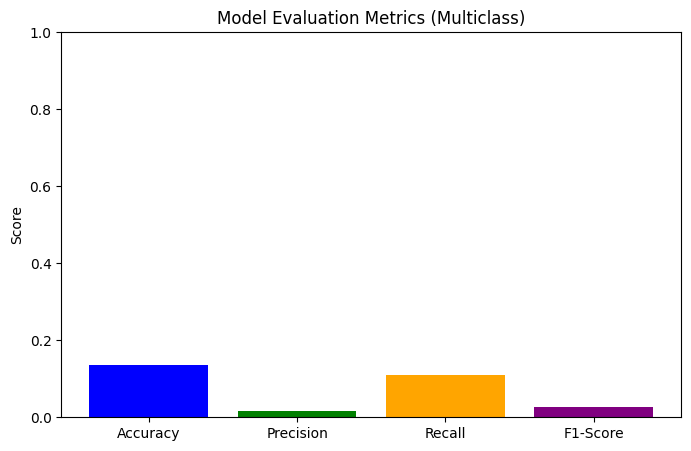

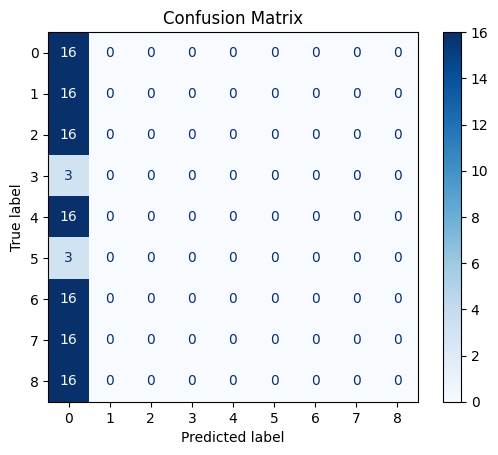

In [8]:
#Predicting on the test dataset.
y_pred_probs = model.predict(test_ds)  #Predicting probabilities.
y_pred = np.argmax(y_pred_probs, axis=1)  #Converting to class indices.
#Getting true labels.
y_true = np.concatenate([y for x, y in test_ds], axis=0)
#Calculating metrics.
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  #Using 'macro' for multiclass.
recall = recall_score(y_true, y_pred, average='macro')        #Using 'macro' for multiclass.
f1 = f1_score(y_true, y_pred, average='macro')                #Using 'macro' for multiclass.
#Printing metrics.
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (macro): {precision:.2f}")
print(f"Recall (macro): {recall:.2f}")
print(f"F1-Score (macro): {f1:.2f}")
#Visualizing metrics.
metrics = [accuracy, precision, recall, f1]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
plt.figure(figsize=(8, 5))
plt.bar(metric_names, metrics, color=['blue', 'green', 'orange', 'purple'])
plt.ylim(0, 1)
plt.title('Model Evaluation Metrics (Multiclass)')
plt.ylabel('Score')
plt.show()
#Confusion Matrix.
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

##### **Conclusion**
The project aimed to classify skin lesion images using a pre-trained **ResNet50** model with **transfer learning**. Below are the key takeaways:
1. **Data Preprocessing**:
   - Images were resized to **224x224** and normalized.
   - Dataset was split into **train, validation and test sets**.
2. **Model Development**:
   - **ResNet50** was fine-tuned by replacing the final layer for classification.
   - Binary Crossentropy loss and Adam optimizer were used.
3. **Evaluation**:
   - The model’s performance on the test set was low:
     - **Accuracy**: ~14%
     - **Precision**: ~2%
     - **Recall**: ~11%
     - **F1-Score**: ~3%
The results highlight the potential of transfer learning but emphasize the need for further optimization to improve performance.
***